## 2024 데이터 통신 설계 기말 프로젝트
### 2번 프로젝트
`tr_bit.csv`를 입력 값으로 받아 **전통적인 QPSK 변조**를 수행하고

AWGN 함수를 거쳐 노이즈를 추가한다.

노이즈를 추가한 입력 값을 앞에서 학습한 딥러닝 기반의 QPSK 복조 (Decoder)를 이용하여 

변환한 비트스트림과 `te_bit.csv` 파일(테스트 셋)을 비교하여 에러를 계산한다 **(BER 계산)**

앞에서 학습한 딥러닝 Decoder의 경우 CNN 기반의 Decoder를 그대로 사용한다.

(각 프로젝트 별로 독립적인 실행 결과를 보장하기 위해 1번 프로젝트와 동일한 코드가 포함되어 있음.)

(가독성을 위해 1번 프로젝트에서 작성한 주석 및 Markdown은 제거함.)

![project2](./assets/project2.png)

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
print(torch.cuda.is_available())

True


In [34]:
# [변경 함수]
def awgn_(input, dB_snr):
    snr = 10**(dB_snr/10)
    signal_power = 1
    awgn_power = signal_power / snr
    # 텐서 계산을 위해 텐서 타입으로 변환
    awgn_power_tensor = torch.tensor(awgn_power, dtype=torch.float32)
    awgn = torch.sqrt(awgn_power_tensor / 2)*(
        torch.randn_like(input, dtype=torch.float32)+1j*torch.randn_like(input, dtype=torch.float32)
    )
    return input + awgn

In [35]:
# QPSK Decoder Model (DNN)
class QPSKDemodulationDNN(nn.Module):
    def __init__(self):
        super(QPSKDemodulationDNN, self).__init__()
        self.fc1 = nn.Linear(2, 8)
        self.fc2 = nn.Linear(8, 4)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

In [36]:
# Training Set 준비
train_df = pd.read_csv('./data/tr_qpsk.csv', header=None)
# 복소수 형태로 변환
train_df[0] = train_df[0].str.replace('i', 'j')  # 'i'를 'j'로 변경 (Python 복소수 표기법에 맞춤)
train_complex_numbers = train_df[0].apply(lambda x: complex(x))

# 실수부와 허수부 분리
train_qpsk_real_parts = train_complex_numbers.apply(lambda x: x.real)
train_qpsk_imag_parts = train_complex_numbers.apply(lambda x: x.imag)

# Ground Truth (dec)
train_dec = np.loadtxt('./data/tr_dec.csv', delimiter=',')
# DataFrame 생성
train_df = pd.DataFrame({'Real': train_qpsk_real_parts, 
                         'Imaginary': train_qpsk_imag_parts, 
                         'dec': train_dec})
# PyTorch 텐서로 변환
train_x_tensor = torch.Tensor(train_df[['Real', 'Imaginary']].values)
train_y_tensor = torch.LongTensor(train_df['dec'].values)

# 미니 배치 학습을 위해 DataLoader 생성
train_data = TensorDataset(train_x_tensor, train_y_tensor)
BATCH_SIZE = 100
train_loader = DataLoader(dataset=train_data, 
                    batch_size=BATCH_SIZE, shuffle=True)

# Test Set 준비
test_df = pd.read_csv('./data/te_qpsk.csv', header=None)
test_df[0] = test_df[0].str.replace('i', 'j')
test_complex_numbers = test_df[0].apply(lambda x: complex(x))

test_qpsk_real_parts = test_complex_numbers.apply(lambda x: x.real)
test_qpsk_imag_parts = test_complex_numbers.apply(lambda x: x.imag)
test_dec = np.loadtxt('./data/te_dec.csv', delimiter=',')

test_df = pd.DataFrame({'Real': test_qpsk_real_parts, 
                        'Imaginary': test_qpsk_imag_parts, 
                        'dec': test_dec})

# PyTorch 텐서로 변환
test_x_tensor = torch.Tensor(test_df[['Real', 'Imaginary']].values)
test_y_tensor = torch.LongTensor(test_df['dec'].values)

# 미니 배치 학습을 위해 DataLoader 생성
test_data = TensorDataset(test_x_tensor, test_y_tensor)
test_loader = DataLoader(dataset=test_data, 
                    batch_size=len(test_data), shuffle=False)


#### 모델 학습 수정
1. 학습 데이터 증강
    - 프로젝트 1에서 학습한 모델의 경우 정확도가 계속 100%로 나와 Overfitting의 우려가 있다.
    - 따라서 학습 데이터에도 `AWGN`를 적용하여 노이즈 발생 데이터를 기반으로 학습을 시키도록 코드를 수정하였다.
2. Epoch 변경
    - 프로젝트 1에서 Loss 값이 예상과 달리 쉽게 떨어지지 않아 Epoch 수를 늘려서 학습을 다시 수행하였다.

In [ ]:
import random
# GPU 사용 여부 확인
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# 모델 초기화
model = QPSKDemodulationDNN().to(device)
# model = QPSKDemodulationCNN()
cel = torch.nn.CrossEntropyLoss()  # 손실 함수
# Adam 사용
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 학습
epochs = 30
loss_lst = []  # 손실 저장
acc_lst = []  # 정확도 저장

for epoch in range(epochs):
    model.train()
    l_sum = 0
    for batch_idx, (x,y) in enumerate(train_loader):
        ########### Overfitting 이슈로 AWGN 추가하여 학습 데이터 증강 ###########
        # 복소수로 변환
        X_test_complex = x[:, 0] + 1j*x[:, 1]
        # awgn 추가
        X_test_noise = awgn_(X_test_complex, random.randint(0, 10))
        # 실수부와 허수부 분리
        X_test_real_parts = X_test_noise.real
        X_test_imag_parts = X_test_noise.imag
        # 텐서로 변환
        X_test_noise_tensor = torch.stack([torch.tensor(X_test_real_parts), torch.tensor(X_test_imag_parts)], dim=1)
        x, y = X_test_noise_tensor.to(device), y.to(device)
        y_pred = model(x)
        optimizer.zero_grad()
        loss = cel(y_pred, y)
        loss.backward()
        optimizer.step()
        l_sum += loss.item()
    loss = l_sum/len(train_loader)
    loss_lst.append(loss)
    model.eval()
    correct = 0
    for batch_idx, (x,y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        predicted = torch.argmax(y_pred, dim=1)
        correct += torch.sum(predicted == y)
    accuracy = correct / len(test_data)
    # 정확도를 CPU로 이동하여 저장 -> 그래프 그릴 때 에러 방지
    acc_lst.append(accuracy.cpu().numpy())
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')


C:\Users\Kyounghwan-Kim\AppData\Local\Temp\ipykernel_3172\3299731685.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_noise_tensor = torch.stack([torch.tensor(X_test_real_parts), torch.tensor(X_test_imag_parts)], dim=1)
c:\Users\Kyounghwan-Kim\anaconda3\envs\space-search\lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1/30, Loss: 0.8984, Accuracy: 1.0000
Epoch 2/30, Loss: 0.8466, Accuracy: 1.0000
Epoch 3/30, Loss: 0.8454, Accuracy: 1.0000
Epoch 4/30, Loss: 0.8488, Accuracy: 1.0000
Epoch 5/30, Loss: 0.8474, Accuracy: 1.0000
Epoch 6/30, Loss: 0.8487, Accuracy: 1.0000
Epoch 7/30, Loss: 0.8480, Accuracy: 1.0000
Epoch 8/30, Loss: 0.8503, Accuracy: 1.0000
Epoch 9/30, Loss: 0.8476, Accuracy: 1.0000
Epoch 10/30, Loss: 0.8446, Accuracy: 1.0000
Epoch 11/30, Loss: 0.8484, Accuracy: 1.0000
Epoch 12/30, Loss: 0.8469, Accuracy: 1.0000
Epoch 13/30, Loss: 0.8474, Accuracy: 1.0000
Epoch 14/30, Loss: 0.8476, Accuracy: 1.0000
Epoch 15/30, Loss: 0.8508, Accuracy: 1.0000
Epoch 16/30, Loss: 0.8458, Accuracy: 1.0000
Epoch 17/30, Loss: 0.8486, Accuracy: 1.0000
Epoch 18/30, Loss: 0.8468, Accuracy: 1.0000
Epoch 19/30, Loss: 0.8493, Accuracy: 1.0000
Epoch 20/30, Loss: 0.8470, Accuracy: 1.0000
Epoch 21/30, Loss: 0.8485, Accuracy: 1.0000
Epoch 22/30, Loss: 0.8473, Accuracy: 1.0000
Epoch 23/30, Loss: 0.8446, Accuracy: 1.00

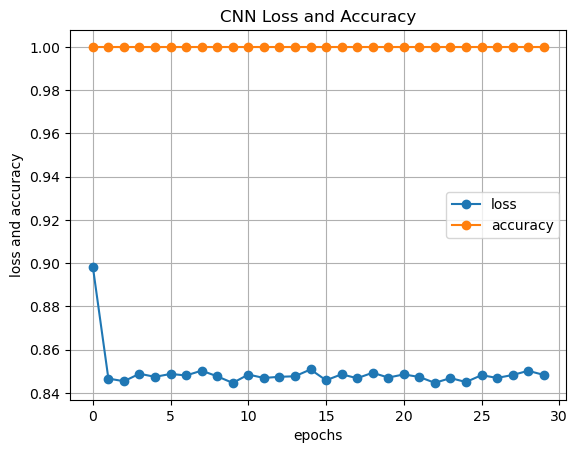

In [38]:
# 손실, 정확도 그래프 출력
plt.plot(range(epochs), loss_lst, marker='o', linestyle='-', label='loss')
plt.plot(range(epochs), acc_lst, marker='o', linestyle='-', label='accuracy')
plt.grid(True)
plt.title('CNN Loss and Accuracy')
plt.xlabel('epochs')
plt.ylabel('loss and accuracy')
plt.legend(('loss', 'accuracy'))
plt.show()

### 전통적인 QPSK 변조 (Encoder)
- 전통적인 QPSK 변조는 복소평면 상에 4개의 심볼로 나타나며, 이들 변조값은 각각 1/√2를 실수부와 허수부에 가지는 복소수 형태입니다.
- 제공해주신 `기말프로젝트.pdf`내의 `QPSK 시스템`을 참고하여 함수를 작성하였습니다.

![alt text](./assets/qpsk.png)

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# QPSK 심볼 생성 함수
def qpsk_modulation(bits_array):
    # bits_array -> [[0, 0], [0, 1], [1, 1], ...]

    symbols = []  # QPSK 심볼 저장
    scale = 1 / np.sqrt(2)  # 파워를 1로 정규화
    
    # 매핑 테이블: 각 비트 쌍을 QPSK 심볼로 변환
    for pair in bits_array:
        if pair[0] == 0 and pair[1] == 0:
            converted = scale * (1 + 1j)  # 0도
        elif pair[0] == 0 and pair[1] == 1:
            converted = scale * (-1 + 1j) # 90도
        elif pair[0] == 1 and pair[1] == 1:
            converted = scale * (-1 - 1j) # 180도
        elif pair[0] == 1 and pair[1] == 0:
            converted = scale * (1 - 1j) # 270도
        symbols.append(converted)

    return symbols

### 1번 프로젝트와 코드 변경점.
- `evaluate_and_plot_ber` 함수 내에서 전통적인 QPSK 시스템을 거치게 되면 반환 값으로 복소수 형태의 값을 반환하기 때문에 함수 내에서 복소수로 변환하는 과정을 생략하였습니다.
### 전통적인 QPSK 변조 과정 추가
- `te_bits.csv`를 로드하고, 해당 값을 전통적인 QPSK 변조 함수인 `qpsk_modulation`에 넣어서 복소수 리스트를 리턴 받는다.

C:\Users\Kyounghwan-Kim\AppData\Local\Temp\ipykernel_3172\439543414.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_noise_tensor = torch.stack([torch.tensor(X_test_real_parts), torch.tensor(X_test_imag_parts)], dim=1)
c:\Users\Kyounghwan-Kim\anaconda3\envs\space-search\lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


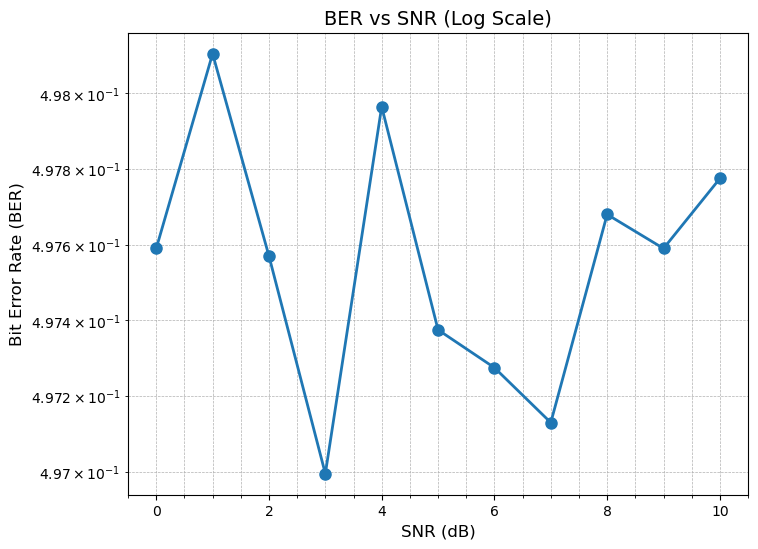

In [40]:
# BER 계산 함수
def calculate_ber(original_bits, predicted_bits):
    original_bits = np.array(original_bits)
    predicted_bits = np.array(predicted_bits)

    # Count the number of bit errors
    bit_errors = np.sum(original_bits != predicted_bits)

    # Calculate BER
    ber = bit_errors / len(original_bits)
    return ber

# BER 그래프 작성 함수
def plot_ber(snr_values, ber_values):
    plt.figure(figsize=(8, 6))
    plt.semilogy(snr_values, ber_values, marker='o', linestyle='-', linewidth=2, markersize=8)
    plt.title("BER vs SNR (Log Scale)", fontsize=14)
    plt.xlabel("SNR (dB)", fontsize=12)
    plt.ylabel("Bit Error Rate (BER)", fontsize=12)
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.minorticks_on()
    plt.show()

# SNR에 따른 BER 계산 및 그래프 작성
def evaluate_and_plot_ber(model, X_test, y_test, snr_range):
    ber_values = []
    for snr_db in snr_range:
        # 복소수로 변환
        # X_test_complex = X_test[:, 0] + 1j*X_test[:, 1]
        # awgn 추가
        X_test_noise = awgn_(X_test, snr_db)
        # 실수부와 허수부 분리
        X_test_real_parts = X_test_noise.real
        X_test_imag_parts = X_test_noise.imag
        # 텐서로 변환
        X_test_noise_tensor = torch.stack([torch.tensor(X_test_real_parts), torch.tensor(X_test_imag_parts)], dim=1)
        
        model.eval()
        with torch.no_grad():
            x = X_test_noise_tensor.to(device)
            y_pred = model(x)
            predicted_dec = torch.argmax(y_pred, dim=1)
        

        # 예측 값 정수 -> 비트 변환
        predicted_bits = []
        for i in range(len(predicted_dec)):
            if predicted_dec[i] == 0:
                predicted_bits.append(0)
                predicted_bits.append(0)
            elif predicted_dec[i] == 1:
                predicted_bits.append(0)
                predicted_bits.append(1)
            elif predicted_dec[i] == 2:
                predicted_bits.append(1)
                predicted_bits.append(0)
            else:
                predicted_bits.append(1)
                predicted_bits.append(1)
        # BER 계산
        ber = calculate_ber(y_test, predicted_bits)
        ber_values.append(ber)

    # BER 그래프 작성
    plot_ber(snr_range, ber_values)

# SNR 범위 설정
snr_range = range(0, 11)  # 0 dB부터 10 dB까지

# BER 평가 및 그래프 작성
y_test = pd.read_csv('./data/te_bits.csv', header=None)
flatten_y_test = y_test.values.flatten()

# 전통적인 QPSK 변조
test_bits = pd.read_csv('./data/te_bits.csv', header=None)
test_x_modulation = qpsk_modulation(test_bits.values)
test_x_modulation_tensor = torch.tensor(test_x_modulation, dtype=torch.complex64)

evaluate_and_plot_ber(model, test_x_modulation_tensor, flatten_y_test, snr_range)


예상과 달리 BER이 떨어지지 않는 현상이 발생하였다. 해당 이슈를 해결하기 위해서는 Decoder의 Overfitting을 해결해야 동시에 해결될 듯 하다.